In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_10245/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


In [3]:
params = {'a': 2}
def printing(a):
    print(a)
printing(**params)

2


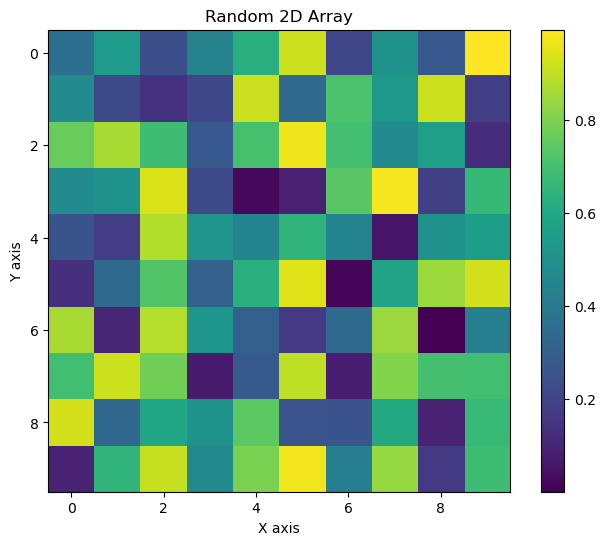

In [4]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [5]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc_best = 0
    val_acc_now = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap):
            net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
            no_val_best_growth_count = 0

        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            val_loss=0
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter/val_loss:{loss:.3f}/{val_loss:.3f}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc_best:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 64, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                cfg = ['M','M',200,200],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.009, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 2, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = True, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:18.422948837280273, tr:18.94%, val:28.41%, val_best:28.41%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.21191048622131 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008999753262144803'], iter_loss:12.474272727966309, tr:42.15%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.20876932144165 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.008999013075636804'], iter_loss:13.922414779663086, tr:53.39%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.56530785560608 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008997779521645792'], iter_loss:10.189095497131348, tr:59.80%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.94817590713501 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.008996052735444862'], iter_loss:9.736132621765137, tr:64.53%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it] 

epoch_time: 44.086235761642456 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.008993832906395582'], iter_loss:9.100517272949219, tr:70.47%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.111820220947266 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.008991120277927223'], iter_loss:7.679866790771484, tr:73.54%, val:59.85%, val_best:63.64%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.46266841888428 seconds

EPOCH 7



7-16/17 iter:79.25%, lr=['0.00898791514751006'], iter_loss:5.879095554351807, tr:75.39%, val:58.33%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.47549033164978 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00898421786662277'], iter_loss:7.031376361846924, tr:81.99%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.85365176200867 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.008980028840713859'], iter_loss:4.333988189697266, tr:87.28%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.360676527023315 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.00897534852915723'], iter_loss:3.1454203128814697, tr:91.27%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.526716470718384 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.008970177445201783'], iter_loss:3.147610664367676, tr:94.34%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:40<00:00,  2.35s/it] 

epoch_time: 40.11393094062805 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.008964516155915151'], iter_loss:2.009941339492798, tr:94.71%, val:70.45%, val_best:71.21%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.93088364601135 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.008958365282121496'], iter_loss:3.052088737487793, tr:94.80%, val:70.45%, val_best:71.21%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]  

epoch_time: 45.79089331626892 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['0.008951725498333446'], iter_loss:2.1937875747680664, tr:98.24%, val:68.56%, val_best:71.21%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.17233657836914 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.008944597532678119'], iter_loss:1.593743920326233, tr:99.35%, val:70.45%, val_best:71.21%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 43.914329051971436 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.008936982166817271'], iter_loss:0.7947255969047546, tr:99.72%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.876145362854004 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.008928880235861586'], iter_loss:1.4535472393035889, tr:99.81%, val:73.11%, val_best:74.62%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.694777727127075 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.008920292628279097'], iter_loss:0.7450997829437256, tr:100.00%, val:73.86%, val_best:74.62%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.50097870826721 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['0.008911220285797746'], iter_loss:0.5984542965888977, tr:100.00%, val:71.21%, val_best:74.62%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.83707880973816 seconds

EPOCH 20



20-16/17 iter:100.00%, lr=['0.008901664203302122'], iter_loss:0.5463345646858215, tr:99.63%, val:70.83%, val_best:74.62%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.823479413986206 seconds

EPOCH 21



21-16/17 iter:100.00%, lr=['0.00889162542872436'], iter_loss:0.4646492004394531, tr:100.00%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.77987313270569 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 22



22-16/17 iter:100.00%, lr=['0.008881105062929218'], iter_loss:0.28408944606781006, tr:100.00%, val:75.00%, val_best:75.00%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.02039885520935 seconds

EPOCH 23



23-16/17 iter:100.00%, lr=['0.00887010425959336'], iter_loss:0.39345401525497437, tr:100.00%, val:75.00%, val_best:75.00%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.237900733947754 seconds

EPOCH 24



24-16/17 iter:100.00%, lr=['0.008858624225078836'], iter_loss:0.31242167949676514, tr:100.00%, val:72.35%, val_best:75.00%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.242653131484985 seconds

EPOCH 25



25-16/17 iter:100.00%, lr=['0.008846666218300804'], iter_loss:0.2264522910118103, tr:100.00%, val:73.11%, val_best:75.00%: 100%|██████████| 17/17 [02:21<00:00,  8.31s/it] 

epoch_time: 141.45359301567078 seconds

EPOCH 26



26-16/17 iter:100.00%, lr=['0.008834231550589459'], iter_loss:0.1870923638343811, tr:100.00%, val:77.27%, val_best:77.27%: 100%|██████████| 17/17 [02:34<00:00,  9.12s/it] 

epoch_time: 155.1097812652588 seconds

EPOCH 27



27-16/17 iter:100.00%, lr=['0.008821321585546242'], iter_loss:0.23161430656909943, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.271804094314575 seconds

EPOCH 28



28-16/17 iter:100.00%, lr=['0.0088079377388943'], iter_loss:0.1955435574054718, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.732638120651245 seconds

EPOCH 29



29-16/17 iter:100.00%, lr=['0.008794081478323244'], iter_loss:0.13469809293746948, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.868534088134766 seconds

EPOCH 30



30-16/17 iter:100.00%, lr=['0.00877975432332819'], iter_loss:0.12333294749259949, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.29939103126526 seconds

EPOCH 31



31-16/17 iter:100.00%, lr=['0.008764957845043135'], iter_loss:0.12291862070560455, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.474881649017334 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 32



32-16/17 iter:100.00%, lr=['0.008749693666068665'], iter_loss:0.11205738037824631, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.39848303794861 seconds

EPOCH 33



33-16/17 iter:100.00%, lr=['0.008733963460294014'], iter_loss:0.09461579471826553, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.35756039619446 seconds

EPOCH 34



34-16/17 iter:100.00%, lr=['0.008717768952713511'], iter_loss:0.14187265932559967, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.546913623809814 seconds

EPOCH 35



35-16/17 iter:100.00%, lr=['0.008701111919237406'], iter_loss:0.10305959731340408, tr:100.00%, val:76.52%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.56215953826904 seconds

EPOCH 36



36-16/17 iter:100.00%, lr=['0.008683994186497129'], iter_loss:0.08980268985033035, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.20508646965027 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 37



37-16/17 iter:100.00%, lr=['0.008666417631644975'], iter_loss:0.09100636839866638, tr:100.00%, val:76.52%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.398592472076416 seconds

EPOCH 38



38-16/17 iter:100.00%, lr=['0.008648384182148252'], iter_loss:0.08154534548521042, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.52344298362732 seconds

EPOCH 39



39-16/17 iter:100.00%, lr=['0.008629895815577915'], iter_loss:0.07940855622291565, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.35338068008423 seconds

EPOCH 40



40-16/17 iter:100.00%, lr=['0.008610954559391704'], iter_loss:0.11616577208042145, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.639180421829224 seconds

EPOCH 41



41-16/17 iter:100.00%, lr=['0.008591562490711808'], iter_loss:0.0595657080411911, tr:100.00%, val:76.89%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]  

epoch_time: 46.14982533454895 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 42



42-16/17 iter:100.00%, lr=['0.008571721736097089'], iter_loss:0.048536207526922226, tr:100.00%, val:76.52%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.261637449264526 seconds

EPOCH 43



43-16/17 iter:100.00%, lr=['0.008551434471309871'], iter_loss:0.07815177738666534, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.611050844192505 seconds

EPOCH 44



44-16/17 iter:100.00%, lr=['0.008530702921077358'], iter_loss:0.06350428611040115, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 45.95576524734497 seconds

EPOCH 45



45-16/17 iter:100.00%, lr=['0.008509529358847655'], iter_loss:0.06215442344546318, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 44.92466711997986 seconds

EPOCH 46



46-16/17 iter:100.00%, lr=['0.008487916106540466'], iter_loss:0.08073011040687561, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it] 

epoch_time: 40.26668095588684 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 47



47-16/17 iter:100.00%, lr=['0.008465865534292464'], iter_loss:0.06369911879301071, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.58277773857117 seconds

EPOCH 48



48-16/17 iter:100.00%, lr=['0.008443380060197386'], iter_loss:0.06360718607902527, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 

epoch_time: 42.16682839393616 seconds

EPOCH 49



49-16/17 iter:100.00%, lr=['0.008420462150040853'], iter_loss:0.045918580144643784, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.29457330703735 seconds

EPOCH 50



50-16/17 iter:100.00%, lr=['0.008397114317029974'], iter_loss:0.05703943967819214, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.93832492828369 seconds

EPOCH 51



51-16/17 iter:100.00%, lr=['0.008373339121517746'], iter_loss:0.046145834028720856, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.779534578323364 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 52



52-16/17 iter:100.00%, lr=['0.008349139170722279'], iter_loss:0.034222524613142014, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.70651340484619 seconds

EPOCH 53



53-16/17 iter:100.00%, lr=['0.008324517118440887'], iter_loss:0.04766283556818962, tr:100.00%, val:76.52%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.042272329330444 seconds

EPOCH 54



54-16/17 iter:100.00%, lr=['0.008299475664759068'], iter_loss:0.05034273490309715, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.52322840690613 seconds

EPOCH 55



55-16/17 iter:100.00%, lr=['0.008274017555754408'], iter_loss:0.05491815507411957, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.85201644897461 seconds

EPOCH 56



56-16/17 iter:100.00%, lr=['0.008248145583195447'], iter_loss:0.04860958829522133, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.52107119560242 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 57



57-16/17 iter:100.00%, lr=['0.008221862584235526'], iter_loss:0.03547070547938347, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.706950426101685 seconds

EPOCH 58



58-16/17 iter:100.00%, lr=['0.008195171441101667'], iter_loss:0.030681097880005836, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.95970392227173 seconds

EPOCH 59



59-16/17 iter:100.00%, lr=['0.008168075080778492'], iter_loss:0.04019699618220329, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.0431706905365 seconds

EPOCH 60



60-16/17 iter:100.00%, lr=['0.008140576474687262'], iter_loss:0.04449990391731262, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.271459341049194 seconds

EPOCH 61



61-16/17 iter:100.00%, lr=['0.008112678638360014'], iter_loss:0.03569164499640465, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.14653968811035 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 62



62-16/17 iter:100.00%, lr=['0.008084384631108882'], iter_loss:0.031217070296406746, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.45461559295654 seconds

EPOCH 63



63-16/17 iter:100.00%, lr=['0.008055697555690605'], iter_loss:0.03955385461449623, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.72522974014282 seconds

EPOCH 64



64-16/17 iter:100.00%, lr=['0.008026620557966279'], iter_loss:0.04979453980922699, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.32673215866089 seconds

EPOCH 65



65-16/17 iter:100.00%, lr=['0.007997156826556369'], iter_loss:0.026716064661741257, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.782641887664795 seconds

EPOCH 66



66-16/17 iter:100.00%, lr=['0.007967309592491052'], iter_loss:0.03498144820332527, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.11321806907654 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 67



67-16/17 iter:100.00%, lr=['0.007937082128855891'], iter_loss:0.028011750429868698, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.256184101104736 seconds

EPOCH 68



68-16/17 iter:100.00%, lr=['0.007906477750432904'], iter_loss:0.02915460430085659, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.445605516433716 seconds

EPOCH 69



69-16/17 iter:100.00%, lr=['0.007875499813337067'], iter_loss:0.03157416731119156, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 46.98560094833374 seconds

EPOCH 70



70-16/17 iter:100.00%, lr=['0.007844151714648273'], iter_loss:0.028479432687163353, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.71225070953369 seconds

EPOCH 71



71-16/17 iter:100.00%, lr=['0.007812436892038803'], iter_loss:0.02685011923313141, tr:100.00%, val:76.89%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.39786624908447 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 72



72-16/17 iter:100.00%, lr=['0.0077803588233963505'], iter_loss:0.034248799085617065, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.272989988327026 seconds

EPOCH 73



73-16/17 iter:100.00%, lr=['0.007747921026442628'], iter_loss:0.028019599616527557, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.52571487426758 seconds

EPOCH 74



74-16/17 iter:100.00%, lr=['0.007715127058347614'], iter_loss:0.036061033606529236, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.30419898033142 seconds

EPOCH 75



75-16/17 iter:100.00%, lr=['0.007681980515339463'], iter_loss:0.03482288122177124, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.04857420921326 seconds

EPOCH 76



76-16/17 iter:100.00%, lr=['0.007648485032310144'], iter_loss:0.01898209936916828, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it] 

epoch_time: 45.07616090774536 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 77



77-16/17 iter:100.00%, lr=['0.007614644282416829'], iter_loss:0.024814072996377945, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.28798699378967 seconds

EPOCH 78



78-16/17 iter:100.00%, lr=['0.007580461976679098'], iter_loss:0.03214189410209656, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.282209396362305 seconds

EPOCH 79



79-16/17 iter:100.00%, lr=['0.007545941863571971'], iter_loss:0.024353833869099617, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.92270112037659 seconds

EPOCH 80



80-16/17 iter:100.00%, lr=['0.00751108772861486'], iter_loss:0.03405923396348953, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.58668327331543 seconds

EPOCH 81



81-16/17 iter:100.00%, lr=['0.007475903393956432'], iter_loss:0.02283138409256935, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.61247944831848 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 82



82-16/17 iter:100.00%, lr=['0.007440392717955473'], iter_loss:0.02683217264711857, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.61815047264099 seconds

EPOCH 83



83-16/17 iter:100.00%, lr=['0.007404559594757776'], iter_loss:0.023222245275974274, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.84123873710632 seconds

EPOCH 84



84-16/17 iter:100.00%, lr=['0.007368407953869102'], iter_loss:0.01611967757344246, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.83048868179321 seconds

EPOCH 85



85-16/17 iter:100.00%, lr=['0.007331941759724267'], iter_loss:0.014721459709107876, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.72445344924927 seconds

EPOCH 86



86-16/17 iter:100.00%, lr=['0.007295165011252396'], iter_loss:0.020847152918577194, tr:100.00%, val:76.14%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.34813117980957 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 87



87-16/17 iter:100.00%, lr=['0.007258081741438393'], iter_loss:0.02359195426106453, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.27146291732788 seconds

EPOCH 88



88-16/17 iter:100.00%, lr=['0.007220696016880686'], iter_loss:0.01726504974067211, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.43534588813782 seconds

EPOCH 89



89-16/17 iter:100.00%, lr=['0.007183011937345269'], iter_loss:0.018914630636572838, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.97044849395752 seconds

EPOCH 90



90-16/17 iter:100.00%, lr=['0.007145033635316126'], iter_loss:0.018326986581087112, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.251250982284546 seconds

EPOCH 91



91-16/17 iter:100.00%, lr=['0.007106765275542052'], iter_loss:0.02198403887450695, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.54118204116821 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 92



92-16/17 iter:100.00%, lr=['0.007068211054579941'], iter_loss:0.02252805605530739, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.29477405548096 seconds

EPOCH 93



93-16/17 iter:100.00%, lr=['0.007029375200334586'], iter_loss:0.012671679258346558, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.97463130950928 seconds

EPOCH 94



94-16/17 iter:100.00%, lr=['0.006990261971595045'], iter_loss:0.017351066693663597, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.75380825996399 seconds

EPOCH 95



95-16/17 iter:100.00%, lr=['0.006950875657567618'], iter_loss:0.01687663048505783, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.548754930496216 seconds

EPOCH 96



96-16/17 iter:100.00%, lr=['0.006911220577405481'], iter_loss:0.020523633807897568, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.952643156051636 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 97



97-16/17 iter:100.00%, lr=['0.0068713010797350465'], iter_loss:0.01979665458202362, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.40756964683533 seconds

EPOCH 98



98-16/17 iter:100.00%, lr=['0.006831121542179084'], iter_loss:0.016353748738765717, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.37953996658325 seconds

EPOCH 99



99-16/17 iter:100.00%, lr=['0.0067906863708766686'], iter_loss:0.015856046229600906, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.86863970756531 seconds

EPOCH 100



100-16/17 iter:100.00%, lr=['0.006749999999999997'], iter_loss:0.021402236074209213, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.94925403594971 seconds

EPOCH 101



101-16/17 iter:100.00%, lr=['0.006709066891268131'], iter_loss:0.014563792385160923, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.0476496219635 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 102



102-16/17 iter:100.00%, lr=['0.006667891533457716'], iter_loss:0.016965631395578384, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.01183032989502 seconds

EPOCH 103



103-16/17 iter:100.00%, lr=['0.006626478441910741'], iter_loss:0.01906636729836464, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 43.989845275878906 seconds

EPOCH 104



104-16/17 iter:100.00%, lr=['0.006584832158039376'], iter_loss:0.013330768793821335, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.60603094100952 seconds

EPOCH 105



105-16/17 iter:100.00%, lr=['0.0065429572488279585'], iter_loss:0.02217860519886017, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.56413817405701 seconds

EPOCH 106



106-16/17 iter:100.00%, lr=['0.006500858306332171'], iter_loss:0.015427165664732456, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.3541464805603 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 107



107-16/17 iter:100.00%, lr=['0.006458539947175472'], iter_loss:0.020322591066360474, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.24776101112366 seconds

EPOCH 108



108-16/17 iter:100.00%, lr=['0.006416006812042825'], iter_loss:0.019340377300977707, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.53956890106201 seconds

EPOCH 109



109-16/17 iter:100.00%, lr=['0.006373263565171803'], iter_loss:0.016881953924894333, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.81345820426941 seconds

EPOCH 110



110-16/17 iter:100.00%, lr=['0.006330314893841098'], iter_loss:0.016339492052793503, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.478692054748535 seconds

EPOCH 111



111-16/17 iter:100.00%, lr=['0.006287165507856509'], iter_loss:0.014985700137913227, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.80160164833069 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 112



112-16/17 iter:100.00%, lr=['0.00624382013903446'], iter_loss:0.015380464494228363, tr:100.00%, val:75.76%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it]

epoch_time: 45.16500377655029 seconds

EPOCH 113



113-16/17 iter:100.00%, lr=['0.006200283540683099'], iter_loss:0.01252591609954834, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.59807729721069 seconds

EPOCH 114



114-16/17 iter:100.00%, lr=['0.006156560487081048'], iter_loss:0.017527563497424126, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.55682635307312 seconds

EPOCH 115



115-16/17 iter:100.00%, lr=['0.006112655772953847'], iter_loss:0.016913751140236855, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.76120114326477 seconds

EPOCH 116



116-16/17 iter:100.00%, lr=['0.006068574212948165'], iter_loss:0.011415088549256325, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.836886405944824 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 117



117-16/17 iter:100.00%, lr=['0.006024320641103809'], iter_loss:0.012749012559652328, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.90363383293152 seconds

EPOCH 118



118-16/17 iter:100.00%, lr=['0.005979899910323621'], iter_loss:0.012537477537989616, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.85050988197327 seconds

EPOCH 119



119-16/17 iter:100.00%, lr=['0.005935316891841311'], iter_loss:0.017872242256999016, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.73993802070618 seconds

EPOCH 120



120-16/17 iter:100.00%, lr=['0.00589057647468726'], iter_loss:0.01797560229897499, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.98099446296692 seconds

EPOCH 121



121-16/17 iter:100.00%, lr=['0.005845683565152387'], iter_loss:0.015597209334373474, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.363399505615234 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 122



122-16/17 iter:100.00%, lr=['0.0058006430862501185'], iter_loss:0.013585037551820278, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.23346138000488 seconds

EPOCH 123



123-16/17 iter:100.00%, lr=['0.005755459977176528'], iter_loss:0.018303802236914635, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.712902307510376 seconds

EPOCH 124



124-16/17 iter:100.00%, lr=['0.005710139192768691'], iter_loss:0.013798980973660946, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.22539710998535 seconds

EPOCH 125



125-16/17 iter:100.00%, lr=['0.00566468570296134'], iter_loss:0.011036551557481289, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.949862480163574 seconds

EPOCH 126



126-16/17 iter:100.00%, lr=['0.005619104492241842'], iter_loss:0.01156405359506607, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.34416198730469 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 127



127-16/17 iter:100.00%, lr=['0.00557340055910361'], iter_loss:0.013980865478515625, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.176032066345215 seconds

EPOCH 128



128-16/17 iter:100.00%, lr=['0.0055275789154979466'], iter_loss:0.0163991991430521, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]  

epoch_time: 47.02711486816406 seconds

EPOCH 129



129-16/17 iter:100.00%, lr=['0.0054816445862844385'], iter_loss:0.014257448725402355, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.37553524971008 seconds

EPOCH 130



130-16/17 iter:100.00%, lr=['0.005435602608679913'], iter_loss:0.010444257408380508, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.290425539016724 seconds

EPOCH 131



131-16/17 iter:100.00%, lr=['0.005389458031706063'], iter_loss:0.015151845291256905, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.11277413368225 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 132



132-16/17 iter:100.00%, lr=['0.005343215915635758'], iter_loss:0.008889513090252876, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.481189012527466 seconds

EPOCH 133



133-16/17 iter:100.00%, lr=['0.005296881331438122'], iter_loss:0.013690817169845104, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.70769023895264 seconds

EPOCH 134



134-16/17 iter:100.00%, lr=['0.005250459360222458'], iter_loss:0.010585509240627289, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.476977586746216 seconds

EPOCH 135



135-16/17 iter:100.00%, lr=['0.005203955092681037'], iter_loss:0.013393158093094826, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.80446791648865 seconds

EPOCH 136



136-16/17 iter:100.00%, lr=['0.0051573736285308504'], iter_loss:0.010926180519163609, tr:100.00%, val:72.73%, val_best:77.27%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.28957414627075 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 137



137-16/17 iter:100.00%, lr=['0.005110720075954368'], iter_loss:0.00963309034705162, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.38801074028015 seconds

EPOCH 138



138-16/17 iter:100.00%, lr=['0.005063999551039367'], iter_loss:0.01102893054485321, tr:100.00%, val:72.73%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.71s/it] 

epoch_time: 46.1244330406189 seconds

EPOCH 139



139-16/17 iter:100.00%, lr=['0.005017217177217898'], iter_loss:0.011784445494413376, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.492897033691406 seconds

EPOCH 140



140-16/17 iter:100.00%, lr=['0.00497037808470444'], iter_loss:0.011143190786242485, tr:100.00%, val:72.73%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.85050320625305 seconds

EPOCH 141



141-16/17 iter:100.00%, lr=['0.004923487409933314'], iter_loss:0.01228006649762392, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 43.933404207229614 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 142



142-16/17 iter:100.00%, lr=['0.004876550294995418'], iter_loss:0.00858467910438776, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it] 

epoch_time: 43.11987352371216 seconds

EPOCH 143



143-16/17 iter:100.00%, lr=['0.0048295718870743415'], iter_loss:0.010341103188693523, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.32729625701904 seconds

EPOCH 144



144-16/17 iter:100.00%, lr=['0.00478255733788191'], iter_loss:0.011743877083063126, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.10928297042847 seconds

EPOCH 145



145-16/17 iter:100.00%, lr=['0.004735511803093247'], iter_loss:0.01275282446295023, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.67057800292969 seconds

EPOCH 146



146-16/17 iter:100.00%, lr=['0.004688440441781398'], iter_loss:0.010662752203643322, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.83891773223877 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 147



147-16/17 iter:100.00%, lr=['0.004641348415851575'], iter_loss:0.012254582718014717, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.35911846160889 seconds

EPOCH 148



148-16/17 iter:100.00%, lr=['0.004594240889475105'], iter_loss:0.009895487688481808, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.317256689071655 seconds

EPOCH 149



149-16/17 iter:100.00%, lr=['0.004547123028523105'], iter_loss:0.009812314994633198, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.78318643569946 seconds

EPOCH 150



150-16/17 iter:100.00%, lr=['0.004499999999999999'], iter_loss:0.013484048657119274, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.536582946777344 seconds

EPOCH 151



151-16/17 iter:100.00%, lr=['0.004452876971476893'], iter_loss:0.011402608826756477, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 46.98972702026367 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 152



152-16/17 iter:100.00%, lr=['0.004405759110524894'], iter_loss:0.009914125315845013, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.562166690826416 seconds

EPOCH 153



153-16/17 iter:100.00%, lr=['0.004358651584148422'], iter_loss:0.01406288705766201, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 46.988929748535156 seconds

EPOCH 154



154-16/17 iter:100.00%, lr=['0.004311559558218601'], iter_loss:0.012062123976647854, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.32348847389221 seconds

EPOCH 155



155-16/17 iter:100.00%, lr=['0.0042644881969067525'], iter_loss:0.010780622251331806, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.708447217941284 seconds

EPOCH 156



156-16/17 iter:100.00%, lr=['0.0042174426621180905'], iter_loss:0.010853040963411331, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.19728755950928 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 157



157-16/17 iter:100.00%, lr=['0.004170428112925658'], iter_loss:0.008328080177307129, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.39621305465698 seconds

EPOCH 158



158-16/17 iter:100.00%, lr=['0.004123449705004579'], iter_loss:0.013247732073068619, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 47.995933532714844 seconds

EPOCH 159



159-16/17 iter:100.00%, lr=['0.004076512590066685'], iter_loss:0.014377989806234837, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.685861349105835 seconds

EPOCH 160



160-16/17 iter:100.00%, lr=['0.0040296219152955596'], iter_loss:0.009552845731377602, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.11548972129822 seconds

EPOCH 161



161-16/17 iter:100.00%, lr=['0.0039827828227821'], iter_loss:0.013899784535169601, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.103219747543335 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 162



162-16/17 iter:100.00%, lr=['0.00393600044896063'], iter_loss:0.01143080834299326, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.60825228691101 seconds

EPOCH 163



163-16/17 iter:100.00%, lr=['0.0038892799240456298'], iter_loss:0.013503078371286392, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.82496881484985 seconds

EPOCH 164



164-16/17 iter:100.00%, lr=['0.0038426263714691484'], iter_loss:0.009884609840810299, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.45937442779541 seconds

EPOCH 165



165-16/17 iter:100.00%, lr=['0.0037960449073189614'], iter_loss:0.012146960012614727, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.17475748062134 seconds

EPOCH 166



166-16/17 iter:100.00%, lr=['0.0037495406397775382'], iter_loss:0.013119310140609741, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.1596782207489 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 167



167-16/17 iter:100.00%, lr=['0.0037031186685618747'], iter_loss:0.010415670461952686, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.69522309303284 seconds

EPOCH 168



168-16/17 iter:100.00%, lr=['0.003656784084364239'], iter_loss:0.010152758099138737, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.42319869995117 seconds

EPOCH 169



169-16/17 iter:100.00%, lr=['0.0036105419682939317'], iter_loss:0.012026967480778694, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.87637686729431 seconds

EPOCH 170



170-16/17 iter:100.00%, lr=['0.003564397391320082'], iter_loss:0.012643537484109402, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.38527870178223 seconds

EPOCH 171



171-16/17 iter:100.00%, lr=['0.0035183554137155583'], iter_loss:0.010213641449809074, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.269935846328735 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 172



172-16/17 iter:100.00%, lr=['0.0034724210845020497'], iter_loss:0.010547048412263393, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.43991208076477 seconds

EPOCH 173



173-16/17 iter:100.00%, lr=['0.003426599440896387'], iter_loss:0.01108465064316988, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.45437026023865 seconds

EPOCH 174



174-16/17 iter:100.00%, lr=['0.003380895507758154'], iter_loss:0.011570601724088192, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.890472412109375 seconds

EPOCH 175



175-16/17 iter:100.00%, lr=['0.0033353142970386574'], iter_loss:0.011517468839883804, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.322951316833496 seconds

EPOCH 176



176-16/17 iter:100.00%, lr=['0.0032898608072313056'], iter_loss:0.013601714745163918, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.9524450302124 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 177



177-16/17 iter:100.00%, lr=['0.0032445400228234677'], iter_loss:0.00863192044198513, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.575706243515015 seconds

EPOCH 178



178-16/17 iter:100.00%, lr=['0.003199356913749877'], iter_loss:0.01569097302854061, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.88395357131958 seconds

EPOCH 179



179-16/17 iter:100.00%, lr=['0.00315431643484761'], iter_loss:0.010296751745045185, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 47.99459266662598 seconds

EPOCH 180



180-16/17 iter:100.00%, lr=['0.0031094235253127365'], iter_loss:0.010091536678373814, tr:100.00%, val:75.38%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.04065728187561 seconds

EPOCH 181



181-16/17 iter:100.00%, lr=['0.0030646831081586846'], iter_loss:0.010426722466945648, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.46989393234253 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 182



182-16/17 iter:100.00%, lr=['0.003020100089676375'], iter_loss:0.00715909618884325, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it] 

epoch_time: 40.62116265296936 seconds

EPOCH 183



183-16/17 iter:100.00%, lr=['0.002975679358896188'], iter_loss:0.008597267791628838, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.07647347450256 seconds

EPOCH 184



184-16/17 iter:100.00%, lr=['0.002931425787051832'], iter_loss:0.011892381124198437, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.610801458358765 seconds

EPOCH 185



185-16/17 iter:100.00%, lr=['0.0028873442270461493'], iter_loss:0.011955752037465572, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.57296180725098 seconds

EPOCH 186



186-16/17 iter:100.00%, lr=['0.00284343951291895'], iter_loss:0.008922784589231014, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.20886778831482 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 187



187-16/17 iter:100.00%, lr=['0.0027997164593168973'], iter_loss:0.010853119194507599, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.62843370437622 seconds

EPOCH 188



188-16/17 iter:100.00%, lr=['0.002756179860965537'], iter_loss:0.009201590903103352, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 47.99620532989502 seconds

EPOCH 189



189-16/17 iter:100.00%, lr=['0.0027128344921434865'], iter_loss:0.008973700925707817, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.785401821136475 seconds

EPOCH 190



190-16/17 iter:100.00%, lr=['0.0026696851061588987'], iter_loss:0.01072694081813097, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.03680920600891 seconds

EPOCH 191



191-16/17 iter:100.00%, lr=['0.0026267364348281953'], iter_loss:0.008138218894600868, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.82690620422363 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 192



192-16/17 iter:100.00%, lr=['0.002583993187957173'], iter_loss:0.014372237026691437, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.89152145385742 seconds

EPOCH 193



193-16/17 iter:100.00%, lr=['0.0025414600528245266'], iter_loss:0.00856421235948801, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.64761686325073 seconds

EPOCH 194



194-16/17 iter:100.00%, lr=['0.0024991416936678275'], iter_loss:0.0068237134255468845, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.29382658004761 seconds

EPOCH 195



195-16/17 iter:100.00%, lr=['0.00245704275117204'], iter_loss:0.00846070609986782, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.55016589164734 seconds

EPOCH 196



196-16/17 iter:100.00%, lr=['0.002415167841960624'], iter_loss:0.00945129245519638, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.167213678359985 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 197



197-16/17 iter:100.00%, lr=['0.002373521558089258'], iter_loss:0.01163480058312416, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.77663445472717 seconds

EPOCH 198



198-16/17 iter:100.00%, lr=['0.0023321084665422808'], iter_loss:0.007631534710526466, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 47.98249387741089 seconds

EPOCH 199



199-16/17 iter:100.00%, lr=['0.0022909331087318666'], iter_loss:0.010904509574174881, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 46.027865171432495 seconds

EPOCH 200



200-16/17 iter:100.00%, lr=['0.0022499999999999994'], iter_loss:0.008404957130551338, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.14387822151184 seconds

EPOCH 201



201-16/17 iter:100.00%, lr=['0.0022093136291233295'], iter_loss:0.00884050689637661, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.705721616744995 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 202



202-16/17 iter:100.00%, lr=['0.0021688784578209152'], iter_loss:0.007917460985481739, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 46.33023810386658 seconds

EPOCH 203



203-16/17 iter:100.00%, lr=['0.0021286989202649515'], iter_loss:0.008972661569714546, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.35495352745056 seconds

EPOCH 204



204-16/17 iter:100.00%, lr=['0.002088779422594517'], iter_loss:0.00937839224934578, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]  

epoch_time: 46.27644920349121 seconds

EPOCH 205



205-16/17 iter:100.00%, lr=['0.0020491243424323805'], iter_loss:0.007340229116380215, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.859771490097046 seconds

EPOCH 206



206-16/17 iter:100.00%, lr=['0.002009738028404953'], iter_loss:0.01065563503652811, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.81192326545715 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 207



207-16/17 iter:100.00%, lr=['0.0019706247996654144'], iter_loss:0.009469344280660152, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.09953832626343 seconds

EPOCH 208



208-16/17 iter:100.00%, lr=['0.001931788945420059'], iter_loss:0.00814049132168293, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]  

epoch_time: 46.68790006637573 seconds

EPOCH 209



209-16/17 iter:100.00%, lr=['0.0018932347244579458'], iter_loss:0.008985876105725765, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.4251983165741 seconds

EPOCH 210



210-16/17 iter:100.00%, lr=['0.0018549663646838725'], iter_loss:0.008636616170406342, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.22910499572754 seconds

EPOCH 211



211-16/17 iter:100.00%, lr=['0.0018169880626547293'], iter_loss:0.01124497689306736, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it] 

epoch_time: 49.93462109565735 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 212



212-16/17 iter:100.00%, lr=['0.0017793039831193143'], iter_loss:0.0076961093582212925, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.20855450630188 seconds

EPOCH 213



213-16/17 iter:100.00%, lr=['0.0017419182585616077'], iter_loss:0.007914945483207703, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.965330362319946 seconds

EPOCH 214



214-16/17 iter:100.00%, lr=['0.0017048349887476045'], iter_loss:0.00923900306224823, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.22726249694824 seconds

EPOCH 215



215-16/17 iter:100.00%, lr=['0.001668058240275733'], iter_loss:0.008800800889730453, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.87578320503235 seconds

EPOCH 216



216-16/17 iter:100.00%, lr=['0.0016315920461308967'], iter_loss:0.008561810478568077, tr:100.00%, val:75.00%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.76098871231079 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 217



217-16/17 iter:100.00%, lr=['0.0015954404052422237'], iter_loss:0.010116524063050747, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 47.98941683769226 seconds

EPOCH 218



218-16/17 iter:100.00%, lr=['0.0015596072820445272'], iter_loss:0.008613026700913906, tr:100.00%, val:74.62%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.0467414855957 seconds

EPOCH 219



219-16/17 iter:100.00%, lr=['0.0015240966060435662'], iter_loss:0.009334254078567028, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.75663447380066 seconds

EPOCH 220



220-16/17 iter:100.00%, lr=['0.0014889122713851383'], iter_loss:0.007690766826272011, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.79173183441162 seconds

EPOCH 221



221-16/17 iter:100.00%, lr=['0.0014540581364280276'], iter_loss:0.007933534681797028, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.21690821647644 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 222



222-16/17 iter:100.00%, lr=['0.0014195380233209011'], iter_loss:0.008658966980874538, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.86036992073059 seconds

EPOCH 223



223-16/17 iter:100.00%, lr=['0.0013853557175831704'], iter_loss:0.010645737871527672, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.29831409454346 seconds

EPOCH 224



224-16/17 iter:100.00%, lr=['0.0013515149676898556'], iter_loss:0.008760363794863224, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.354262351989746 seconds

EPOCH 225



225-16/17 iter:100.00%, lr=['0.0013180194846605369'], iter_loss:0.010380009189248085, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.92897963523865 seconds

EPOCH 226



226-16/17 iter:100.00%, lr=['0.0012848729416523863'], iter_loss:0.006943182088434696, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.50843954086304 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 227



227-16/17 iter:100.00%, lr=['0.0012520789735573708'], iter_loss:0.008710933849215508, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.773579120635986 seconds

EPOCH 228



228-16/17 iter:100.00%, lr=['0.0012196411766036495'], iter_loss:0.00942858587950468, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.44395208358765 seconds

EPOCH 229



229-16/17 iter:100.00%, lr=['0.0011875631079611975'], iter_loss:0.009361823089420795, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.404961585998535 seconds

EPOCH 230



230-16/17 iter:100.00%, lr=['0.0011558482853517259'], iter_loss:0.00647768983617425, tr:100.00%, val:74.24%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.25716781616211 seconds

EPOCH 231



231-16/17 iter:100.00%, lr=['0.0011245001866629324'], iter_loss:0.006752598565071821, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.87888717651367 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 232



232-16/17 iter:100.00%, lr=['0.0010935222495670972'], iter_loss:0.006898530758917332, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.04707884788513 seconds

EPOCH 233



233-16/17 iter:100.00%, lr=['0.0010629178711441104'], iter_loss:0.009774400852620602, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.01389765739441 seconds

EPOCH 234



234-16/17 iter:100.00%, lr=['0.0010326904075089493'], iter_loss:0.006629103794693947, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.79875159263611 seconds

EPOCH 235



235-16/17 iter:100.00%, lr=['0.0010028431734436314'], iter_loss:0.009443673305213451, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.846617460250854 seconds

EPOCH 236



236-16/17 iter:100.00%, lr=['0.0009733794420337217'], iter_loss:0.007063120137900114, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.603516578674316 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 237



237-16/17 iter:100.00%, lr=['0.0009443024443093946'], iter_loss:0.006948024500161409, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.66999793052673 seconds

EPOCH 238



238-16/17 iter:100.00%, lr=['0.0009156153688911172'], iter_loss:0.00728223379701376, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it] 

epoch_time: 48.11390280723572 seconds

EPOCH 239



239-16/17 iter:100.00%, lr=['0.0008873213616399858'], iter_loss:0.007344570476561785, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.51088619232178 seconds

EPOCH 240



240-16/17 iter:100.00%, lr=['0.0008594235253127373'], iter_loss:0.007026566192507744, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.13278841972351 seconds

EPOCH 241



241-16/17 iter:100.00%, lr=['0.0008319249192215059'], iter_loss:0.00788731686770916, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.80620551109314 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 242



242-16/17 iter:100.00%, lr=['0.0008048285588983322'], iter_loss:0.007689539343118668, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.42246460914612 seconds

EPOCH 243



243-16/17 iter:100.00%, lr=['0.0007781374157644716'], iter_loss:0.008133843541145325, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.810632944107056 seconds

EPOCH 244



244-16/17 iter:100.00%, lr=['0.0007518544168045528'], iter_loss:0.00790159497410059, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.90288305282593 seconds

EPOCH 245



245-16/17 iter:100.00%, lr=['0.0007259824442455926'], iter_loss:0.00887022539973259, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]  

epoch_time: 46.79853701591492 seconds

EPOCH 246



246-16/17 iter:100.00%, lr=['0.0007005243352409325'], iter_loss:0.008783994242548943, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.351229190826416 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 247



247-16/17 iter:100.00%, lr=['0.0006754828815591133'], iter_loss:0.009236029349267483, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.88017702102661 seconds

EPOCH 248



248-16/17 iter:100.00%, lr=['0.0006508608292777206'], iter_loss:0.01253638043999672, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.85330533981323 seconds

EPOCH 249



249-16/17 iter:100.00%, lr=['0.0006266608784822543'], iter_loss:0.008772530592978, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]   

epoch_time: 48.95152235031128 seconds

EPOCH 250



250-16/17 iter:100.00%, lr=['0.000602885682970027'], iter_loss:0.007239084225147963, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it] 

epoch_time: 49.26489853858948 seconds

EPOCH 251



251-16/17 iter:100.00%, lr=['0.0005795378499591471'], iter_loss:0.006861749105155468, tr:100.00%, val:73.11%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.85499978065491 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 252



252-16/17 iter:100.00%, lr=['0.0005566199398026142'], iter_loss:0.009845794178545475, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.03598880767822 seconds

EPOCH 253



253-16/17 iter:100.00%, lr=['0.0005341344657075356'], iter_loss:0.008818316273391247, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it] 

epoch_time: 49.934804916381836 seconds

EPOCH 254



254-16/17 iter:100.00%, lr=['0.000512083893459534'], iter_loss:0.007610783912241459, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.54434394836426 seconds

EPOCH 255



255-16/17 iter:100.00%, lr=['0.0004904706411523452'], iter_loss:0.009281276725232601, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.464356899261475 seconds

EPOCH 256



256-16/17 iter:100.00%, lr=['0.0004692970789226432'], iter_loss:0.010397371836006641, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.7748646736145 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 257



257-16/17 iter:100.00%, lr=['0.0004485655286901294'], iter_loss:0.009458079934120178, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.76580452919006 seconds

EPOCH 258



258-16/17 iter:100.00%, lr=['0.0004282782639029131'], iter_loss:0.011477694846689701, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.082303047180176 seconds

EPOCH 259



259-16/17 iter:100.00%, lr=['0.00040843750928819185'], iter_loss:0.00927345734089613, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.158100605010986 seconds

EPOCH 260



260-16/17 iter:100.00%, lr=['0.0003890454406082968'], iter_loss:0.010128599591553211, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.995699882507324 seconds

EPOCH 261



261-16/17 iter:100.00%, lr=['0.00037010418442208606'], iter_loss:0.010816479101777077, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.01925873756409 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 262



262-16/17 iter:100.00%, lr=['0.00035161581785174737'], iter_loss:0.008547442965209484, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.21170377731323 seconds

EPOCH 263



263-16/17 iter:100.00%, lr=['0.0003335823683550239'], iter_loss:0.008103111758828163, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.28413391113281 seconds

EPOCH 264



264-16/17 iter:100.00%, lr=['0.00031600581350286913'], iter_loss:0.007659652270376682, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it] 

epoch_time: 44.11450219154358 seconds

EPOCH 265



265-16/17 iter:100.00%, lr=['0.00029888808076259234'], iter_loss:0.008199924603104591, tr:100.00%, val:73.48%, val_best:77.27%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it] 

epoch_time: 42.08154344558716 seconds

EPOCH 266



266-16/17 iter:100.00%, lr=['0.0002822310472864886'], iter_loss:0.009708668105304241, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.2509024143219 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 267



267-16/17 iter:100.00%, lr=['0.0002660365397059856'], iter_loss:0.008915946818888187, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.76487994194031 seconds

EPOCH 268



268-16/17 iter:100.00%, lr=['0.00025030633393133565'], iter_loss:0.0054892608895897865, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.382994174957275 seconds

EPOCH 269



269-16/17 iter:100.00%, lr=['0.00023504215495686513'], iter_loss:0.0084441639482975, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]  

epoch_time: 39.58251976966858 seconds

EPOCH 270



270-16/17 iter:100.00%, lr=['0.00022024567667180923'], iter_loss:0.009090283885598183, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.648730754852295 seconds

EPOCH 271



271-16/17 iter:100.00%, lr=['0.0002059185216767544'], iter_loss:0.010298577137291431, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.25476050376892 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 272



272-16/17 iter:100.00%, lr=['0.0001920622611056975'], iter_loss:0.008246741257607937, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.74047899246216 seconds

EPOCH 273



273-16/17 iter:100.00%, lr=['0.00017867841445375632'], iter_loss:0.005839430261403322, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.352253675460815 seconds

EPOCH 274



274-16/17 iter:100.00%, lr=['0.00016576844941053865'], iter_loss:0.00823727436363697, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.84203028678894 seconds

EPOCH 275



275-16/17 iter:100.00%, lr=['0.0001533337816991927'], iter_loss:0.010329167358577251, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.44571280479431 seconds

EPOCH 276



276-16/17 iter:100.00%, lr=['0.00014137577492116026'], iter_loss:0.009596616961061954, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.536802768707275 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 277



277-16/17 iter:100.00%, lr=['0.00012989574040663825'], iter_loss:0.009977913461625576, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.89463496208191 seconds

EPOCH 278



278-16/17 iter:100.00%, lr=['0.00011889493707077878'], iter_loss:0.007122614420950413, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.73880434036255 seconds

EPOCH 279



279-16/17 iter:100.00%, lr=['0.00010837457127563712'], iter_loss:0.010017777793109417, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.511202812194824 seconds

EPOCH 280



280-16/17 iter:100.00%, lr=['9.833579669787496e-05'], iter_loss:0.008214062079787254, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.650310754776 seconds

EPOCH 281



281-16/17 iter:100.00%, lr=['8.877971420225216e-05'], iter_loss:0.008951099589467049, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.02997303009033 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 282



282-16/17 iter:100.00%, lr=['7.97073717209013e-05'], iter_loss:0.009422975592315197, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.518083572387695 seconds

EPOCH 283



283-16/17 iter:100.00%, lr=['7.111976413841157e-05'], iter_loss:0.008323367685079575, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.53673696517944 seconds

EPOCH 284



284-16/17 iter:100.00%, lr=['6.301783318272761e-05'], iter_loss:0.009272802621126175, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.621601581573486 seconds

EPOCH 285



285-16/17 iter:100.00%, lr=['5.540246732188056e-05'], iter_loss:0.008123276755213737, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.336976528167725 seconds

EPOCH 286



286-16/17 iter:100.00%, lr=['4.827450166655253e-05'], iter_loss:0.007975012995302677, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.59055972099304 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 287



287-16/17 iter:100.00%, lr=['4.1634717878503836e-05'], iter_loss:0.011563384905457497, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.48272895812988 seconds

EPOCH 288



288-16/17 iter:100.00%, lr=['3.5483844084850076e-05'], iter_loss:0.009118322283029556, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.58833932876587 seconds

EPOCH 289



289-16/17 iter:100.00%, lr=['2.982255479821601e-05'], iter_loss:0.006442138459533453, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.263192892074585 seconds

EPOCH 290



290-16/17 iter:100.00%, lr=['2.465147084277021e-05'], iter_loss:0.009921764954924583, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.59716868400574 seconds

EPOCH 291



291-16/17 iter:100.00%, lr=['1.997115928614003e-05'], iter_loss:0.010968330316245556, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.70002889633179 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 292



292-16/17 iter:100.00%, lr=['1.5782133377230344e-05'], iter_loss:0.007452281191945076, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.61545252799988 seconds

EPOCH 293



293-16/17 iter:100.00%, lr=['1.2084852489938577e-05'], iter_loss:0.008201316930353642, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.00628972053528 seconds

EPOCH 294



294-16/17 iter:100.00%, lr=['8.879722072777992e-06'], iter_loss:0.008376071229577065, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.41567277908325 seconds

EPOCH 295



295-16/17 iter:100.00%, lr=['6.167093604417755e-06'], iter_loss:0.007257945369929075, tr:100.00%, val:73.86%, val_best:77.27%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.030399799346924 seconds

EPOCH 296



296-10/17 iter:100.00%, lr=['3.947264555137278e-06'], iter_loss:0.009291381575167179, tr:100.00%, val:73.86%, val_best:77.27%:  59%|█████▉    | 10/17 [00:17<00:12,  1.79s/it]

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"min": 0.001, "max": 0.01},
#         "BATCH": {"values": [64]},
#         "decay": {"values": [0.5]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [5,6,7,8,9,10]},
#         "epoch_num": {"values": [15]},
#         "dvs_duration": {"values": [100_000, 25_000, 50_000, 75_000]},
#         "dvs_clipping": {"values": [1,2,3,4,5]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [True, False]},
#         "surrogate": {"values": ['rectangle', 'sigmoid', 'hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [True, False]},
#         "cfg": {"values": [['M','M',200,200]]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg

#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "3",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()